In [1]:
from utils import *
import utils

C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
GAME = 'CartPole-v1'
env = gym.make(GAME)
S, A = env.observation_space.shape[0], env.action_space.n
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Box(4,)
Discrete(2)
(-inf, inf)


In [3]:
class TauEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_embed=64, num_outputs=128):
        ''' num of tau embeddings, output after Dense layer '''
        super().__init__()
        self.i = tf.range(1,num_embed+1, dtype=tf.float32)[None,None,:] # [1,1,e]
        self.W1 = tf.keras.layers.Dense(num_outputs)
    
    def call(self, tau):
        ''' [b,N,1] -> [b,N,e] -> [b,N,o], b-batch size, 
        N-num quantile samples, e-num embed, o-num outputs '''
        # [b,N,e] = [b,N,1] * [1,1,e]
        e = tau * self.i # [b,N,e]
        e = tf.cos(np.pi * e) # [b,N,e]
        return self.W1(e) # [b,N,o]

In [4]:
class Model(tf.keras.Model):
    def __init__(self, S, A):
        super().__init__()
        self.E = TauEmbedding(num_embed=8, num_outputs=32)
        self.W1 = tf.keras.layers.Dense(32, 'relu') # must be same as self.E outputs
        self.W2 = tf.keras.layers.Dense(32, 'relu')
        self.W3 = tf.keras.layers.Dense(A)
        self.call(np.ones([32,S],dtype=np.float32))
    
    def call(self, x, N=8): # num quantile samples
        ''' [b,S] -> [b,N,A], [b,N,1] (returns distr of Q values and sampled tau)
            b-batch size, S-num state, A-num action, N-num tau samples '''
        tau = tf.random.uniform([x.shape[0], N, 1], minval=0, maxval=1) # [b,N,1]
        e = self.E(tau) # [b,N,128]
        x = self.W1(x)[:,None,:] # [b,1,128]
        x = x * e # [b,N,128]
        x = self.W2(x) # [b,N,32]
        x = self.W3(x) # [b,N,A]
        return x, tau # [b,N,A], [b,N,1]
    
create_nn = Model

In [5]:
def quantile_regression_loss(Za, Za_hat, tau, kappa=1.0):
    ''' Z(x,a), Z_hat(x,a), tau of Z(x,a), kappa -> loss;
        [b,N], [b,N'], [b,N,1], [] -> [] '''
    def huber_loss(error, k):
        return tf.where( tf.abs(error) < k, 0.5 * error**2, k*(tf.abs(error)-0.5*k) )
    error = Za_hat[:,None,:] - Za[:,:,None] # [b,N',N] bellman error
    H = huber_loss(error, kappa) / kappa # [b,N',N]
    L = tf.where( error<0 , (1-tau)*H , tau*H ) # [b,N',N]
    L = tf.reduce_sum(L, axis=1) # [b,N']
    L = tf.reduce_mean(L, axis=1) # [b]
    return tf.reduce_mean(L) # []

In [6]:
class Agent():
    def __init__(self, num_states, num_actions, lr, gamma=0.99, N=8, N_prime=8, N_test=8):
        self.S, self.A = num_states, num_actions
        self.optimizer = tf.optimizers.Adam(lr)
        self.y = gamma
        self.N, self.Np, self.K = N, N_prime, N_test # num samples for training Qnn and Tnn/testing Qnn
        self.Qnn = create_nn(self.S, self.A) # Q online network
        self.Tnn = create_nn(self.S, self.A) # Target network
        self.Tnn.set_weights( self.Qnn.get_weights() )
        self.batch_size = 32 # batch size
        self.swap_iters = 100 # if iter > this: swap/copy networks
        self._step = 1 # step count to construct epsilon and swap networks
        self.D = deque(maxlen=5000) # experience replay buffer
        self.step2epsilon = create_epsilon_fn([(1.0, 0, 1e4)], min_e=0.05)
#         self.step2epsilon = lambda i: .01 + .99 * np.exp(-i/500)
    
    def first_step(self, s, sdict): # [S]
        a = np.random.randint(self.A) # [] (random move)
        self.s, self.a = s, a # save prev state + action + q value
        # init plot values if not inited
        for a in range(self.A):
            sdict[f'action{a}'] += 0
            sdict[f'Qaction{a}'] += 0
        sdict['epsilon'] += 0
        sdict['loss'] += 0
        return a
        
    def step(self, r, s, sdict): # [], [S]
        sdict['state'] += float(np.max(s))
        # append tuple to experience replay
        self.D.append([self.s, self.a, r, s, False]) # s, a, r, s', done(bool)
        if len(self.D) < self.batch_size: loss = 0
        else: loss = self.calculate_loss(self.batch_size, sdict)
        sdict['loss'] += float(loss)
        # copy Q network to T network
        if self._step % self.swap_iters == 0:
            self.Tnn.set_weights( self.Qnn.get_weights() )
        # update other vars
        epsilon = self.step2epsilon(self._step)
        sdict['epsilon'] += epsilon
        self._step += 1
        # select action from Q network
        Z, _ = self.Qnn(s[None,:], N=self.K) # [1,N,A]
        Q = tf.reduce_mean(Z, axis=1) # [1,A]
        a = epsilon_greedy(Q, epsilon) # []
        for a_ in range(self.A): sdict[f'Qaction{a_}'] += float(Q[0,a_])
        sdict[f'action{a}'] += 1
        # remember last state + action
        self.s, self.a = s, a
        return a
    
    def calculate_loss(self, b, sdict): # batch size
        # select batch from experience replay
        B = random.sample(self.D, b) # random batch from experience replay
        S,A,R,Sn,Done = [np.squeeze(np_map(lambda x: x[j], B)) for j in range(5)] # all w/ shape [b,X] or [b]
        Done, A = Done.astype(bool), A.astype(int) # [b], [b]
        R, Done = R[:,None], Done[:,None] # [b,1], [b,1]
        # pick action a at s' w/ Qnn
        Z, _ = self.Qnn(Sn, N=self.N) # [b,N,A]
        Q = tf.reduce_mean(Z, axis=1) # [b,A]
        Qa = tf.argmax(Q, axis=1) # [b]
        # calculate Z of next state s' using action a from Qnn
        Z, _ = self.Tnn(Sn, N=self.Np) # [b,N',A]
        Za_next = pick_action_values(values=Z, actions=Qa) # [b,N']
        # [b,N'] = [b,1] + ~[b,1] * [] * [b,N']
        Za_hat = R + ~Done * self.y * Za_next
        # train nn for 1 epoch
        with tf.GradientTape() as tape:
            Z, tau = self.Qnn(S, N=self.N) # [b,N,A], [b,N,1];    Z(s)
            Za = pick_action_values(values=Z, actions=A) # [b,N]; Z(s,a)
            loss = quantile_regression_loss(Za, Za_hat, tau)
        # calc + update gradients
        nn_vars = self.Qnn.trainable_variables
        grads = tape.gradient(loss, nn_vars)
        self.optimizer.apply_gradients(zip(grads, nn_vars))
        return loss
    
    def last_step(self, r, sdict):
        self.D.append([self.s, self.a, r, self.s, True]) # s, a, r, s', done

In [7]:
agent_fn = lambda S,A,env_fn=None: Agent(num_states=S, num_actions=A, lr=1e-3, gamma=0.99)

In [12]:
test_agent_on_simple_games(agent_fn, 'IQN', game_dict={'CartPole-v1':500})

True

In [9]:
d = pd.DataFrame()

In [10]:
agent = agent_fn(S,A)
exp = Experiment(env, agent)

In [11]:
df = exp.run(200, 1, name='IQN')
d = d.append(df)

KeyboardInterrupt: 

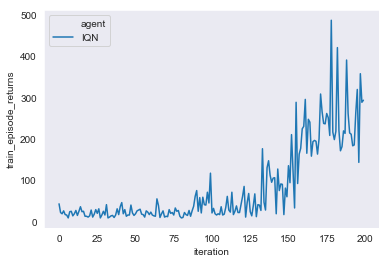

In [12]:
plot_df(df)

[0 0 0 0 0 0 0 0]


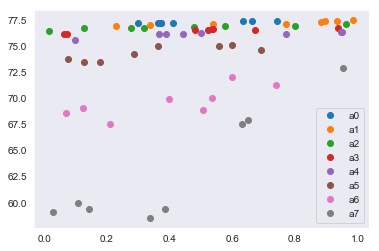

In [17]:
s = env.reset()
As = np.random.choice(A, size=[10])
As = np.zeros([8]).astype(int)
print(As)
for i,a in enumerate(As):
    s,_,done,_ = env.step(a)
    z, tau = exp.agent.Qnn(s[None,:])
    z, tau = np.squeeze(z), np.squeeze(tau)
    z0, z1 = z[:,0], z[:,1]
    plt.plot(tau, z1, 'o', label='a'+str(i))
plt.legend()

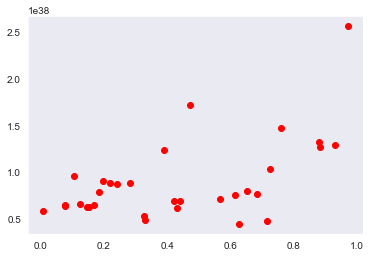

In [68]:
s = env.observation_space.sample()[None,:]
z, tau = exp.agent.Qnn(s)
z, tau = np.squeeze(z), np.squeeze(tau)
z0, z1 = z[:,0], z[:,1]
plt.plot(tau, z0, 'ro')

In [14]:
df = load_my_benchmark('CartPole-v1')

C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior a

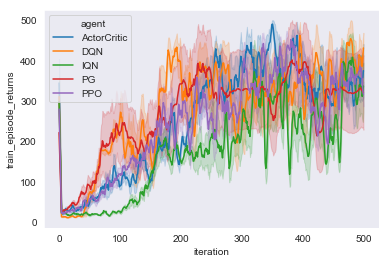

In [16]:
plot_df(df, rolling_mean=5)